<a href="https://colab.research.google.com/github/phantom-balance/HybridEnergy/blob/master/Solar_Battery_gasifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEW

In [1]:
# pymoo used for optimization
from IPython.display import clear_output
!pip install pymoo
clear_output()

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymoo
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

In [75]:
# reading the hourly energy csv file "contains hourly data for deficits, solar radiation and ambient air temperature(Jumla)"
df = pd.read_csv('HOURLY_DATA.csv')
# df = df[0:500]
'''
     csv file has deficit energy in MWh, solar radiation(ghi) in W/m2, air temperature in celcius.
    We perform the analysis in terms of KW.
'''
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

In [76]:
df.describe()

,Unnamed: 0,ghi,air_temperature,deficit_energy
count,183960.000000,183960.000000,183960.000000,1.839600e+05
mean,91979.500000,0.218271,11.596737,2.363687e+05
std,53104.822097,0.311458,8.223487,1.422785e+06
min,0.000000,0.000000,-8.630000,-4.837150e+06
25%,45989.750000,0.000000,4.888750,-7.083003e+05
50%,91979.500000,0.005384,12.802500,7.045418e+05
75%,137969.250000,0.403645,17.676667,1.265331e+06
max,183959.000000,1.147850,29.931667,2.438273e+06


In [8]:
'''
    All the necessary constants required for modeling.
'''
N = 20 # project_life
i = 0.06 # interest_rate

solar_cost_unit = 727 # usd/kW(capex)
solar_OM = 4 # usd/kW.year(opex)

CRF = (i*((1+i)**N))/(((1+i)**N)-1) # capital recovery factor
d_f = 0.88 #derating_factor
Gt_stc = 1 #kw/m2
ap = -0.0035 #solar mod temp coeff of power(%/oC)
T_cstc = 25 #oC standard temp
NOCT = 45 #oC
n_bat = 0.92 #round trip efficieny

gasifier_cost_unit = 2300 # usd/kW(capex)
gasifier_OM = 2 # usd/kW.year(opex)
gasifier_CUF = 0.55 # capacity utilization factor

battery_cost_unit = 223.24 # usd/kW(capex)
battery_OM_per = 1.5 # 1.5% of capex annuity(opex)

In [10]:
'''
    Calculating the Annualized system cost(ASC) and the levelised cost of energy(LCOE)
'''
def cost_pv(solar):
  solar_cost = solar*((CRF*solar_cost_unit)+solar_OM)
  return solar_cost

def cost_gasifier(gasifier):
  gasifier_cost = gasifier*((CRF*gasifier_cost_unit)+gasifier_OM)
  return gasifier_cost

def cost_battery(battery):
  battery_cap = battery*battery_cost_unit
  battery_op = battery_cap*CRF*battery_OM_per/100
  battery_cost = battery_cap*CRF+battery_op
  return battery_cost

def LCOE(total_energy_prod, solar, gasifier, battery):
  ASC = cost_pv(solar)+cost_gasifier(gasifier)+cost_battery(battery)
  energy_prod_per_year = total_energy_prod/N
  lcoe = ASC/(energy_prod_per_year)
  return ASC, lcoe

In [11]:
'''
    Calculating the energy produced by the solar panel and gasifier.
'''
def solar_ene_prod(solar_rate, solar_rad, temp):
  T_cell = temp+Gt_stc*((NOCT-20)/0.8)
  p_op = solar_rate*d_f*(solar_rad/Gt_stc)*(1+ap*(T_cell-T_cstc))
  return p_op

def gasifier_ene_prod(gasifier_rate):
  return gasifier_rate*gasifier_CUF

In [45]:
'''
    Hybrid Energy system operational strategy
'''
def Energy_prod_(energy_def, battery_E, battery_max, solar_rate, solar_rad, gasifier_rate, temp):
  energy_def=-energy_def
  energy_prod = 0
  energy_served = 0
  solar_energy = 0
  gasifier_energy = 0
  battery_E_up = battery_E
  battery_supply = 0
  solar_energy = solar_ene_prod(solar_rate, solar_rad, temp)

  if energy_def>0:
    '''
    Energy deficit strategy
    '''
    if solar_energy-energy_def<0:
      '''
      Solar cannot fulfill the energy deficit.
      Run battery and gasifier.
      '''
      # req_energy needs to be addressed by gasifier and battery
      req_energy = energy_def-solar_energy
      energy_served+=solar_energy

      if battery_E>battery_max*0.3:
        if req_energy<=(battery_E-battery_max*0.3):
          '''
          req_energy met by only battery
          '''
          battery_supply = req_energy
          battery_E_up = battery_E-req_energy
          energy_served+=battery_supply

        else:
          '''
          req_energy met by battery and gasifier
          '''
          gasifier_E_req = req_energy-(battery_E-battery_max*0.3)
          battery_supply = battery_E-0.3*battery_max
          energy_served+=battery_supply
          battery_E_up = 0.3*battery_max
          gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

          if gasifier_energy_op>gasifier_E_req:
            gasifier_energy = gasifier_E_req
            energy_served+=gasifier_energy

          else:
            '''
            Hybrid energy system cannot fulfill the energy deficit.
            New hybrid combination required.
            '''
            print("# THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

      else:
        '''
        req_energy met only by gasifier
        '''
        gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

        if req_energy<gasifier_energy_op:
          gasifier_energy = req_energy
          energy_served+=gasifier_energy
        else:
          '''
          Hybrid energy system cannot fulfill the energy deficit.
          New hybrid combination required.
          '''
          print("THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

    else:
      '''
      Solar can fulfill the energy deficit.
      Extra energy from the solar panel is used to charge the battery.
      '''
      energy_served+=energy_def # solar panel served the entire deficit energy
      Pch_t = solar_energy-energy_def # extra energy from solar used for charging battery
      Ech_t = Pch_t*n_bat

      if Ech_t<=battery_max-battery_E:
        battery_E_up = battery_E+Ech_t

      else:
        battery_E_up = battery_max
        E_dump = Ech_t - (battery_max-battery_E)
        energy_served+=E_dump
        Ech_t = battery_max-battery_E

    energy_prod = solar_energy + gasifier_energy

  else :
    '''
    Energy surplus strategy
    '''
    energy_prod=solar_energy+gasifier_energy
    surplus_ene = abs(energy_def)

    Pch_t = solar_energy
    Ech_t = Pch_t*n_bat

    if Ech_t<=battery_max-battery_E:
      battery_E_up = battery_E+Ech_t

    else:
      battery_E_up = battery_max
      E_dump = Ech_t - (battery_max-battery_E)
      energy_served+=E_dump
      Ech_t = battery_max-battery_E

  return energy_served, battery_supply, battery_E_up, solar_energy, gasifier_energy

In [78]:
'''
    Optimization for minimizing the LCOE.
'''
class ProblemWrapper(Problem):
  def _evaluate(self, designs, out, *args, **kwargs):
    res = []
    res1 =[]
    for design in designs:
      solar, gasifier, battery = design

      count = 0
      Energy_prod_N = 0 #total energy throughout the project life produced
      battery_E = battery

      for i in range(len(df)):
        n_battery_E = battery_E
        Energy_served,battery_supply, battery_E, _, _ = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
        Energy_prod_N += Energy_served
        energy_tot = df['deficit_energy'][i]+Energy_served+battery_supply
        energy_tot = round(energy_tot, 4)

        if energy_tot<0 and count!=1:
          count = 1

      asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
      res.append(lcoe)
      res1.append(count)
    out['F']=np.array(res)
    out['H']=np.array(res1)

problem = ProblemWrapper(n_var=3, n_obj=1, n_eq_constr=1, xl=[54061102, 8794909, 540611*6], xu=[54062102, 8794911, 540621*6])

In [79]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import IntegerRandomSampling
algorithm = GA(pop_size=1,
               sampling=IntegerRandomSampling(),
               eliminate_duplicate=True)
stop_criteria = ('n_gen', 1)

In [80]:
%%time
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   seed=42,
                   save_history=True)

54061204 8794909 3243680
CPU times: user 6.92 s, sys: 0 ns, total: 6.92 s
Wall time: 6.93 s


In [81]:
'''
Optimized results for SOO.
'''
solar, gasifier, battery = results.X
print(f"Solar:{solar}KW, Gasifier: {gasifier}KW, Battery: {battery}KWh || LCOE: {results.F}USD/KWh")

Solar:54061204KW, Gasifier: 8794909KW, Battery: 3243680KWh || LCOE: [0.06619357]USD/KWh


In [ ]:
'''
Convergence plot for SOO.
'''
import numpy as np
import matplotlib.pyplot as plt

n_evals = np.array([e.evaluator.n_eval for e in results.history])
opt = np.array([e.opt[0].F for e in results.history])

plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.xlabel("number of function evaluations")
plt.ylabel("LCOE(USD/KWh)")
plt.show()

In [58]:
'''
Viewing the operation of the optimized hybrid energy system.
'''
solar, gasifier, battery = results.X

solar_array = []
gasifier_array = []
battery_array = []
battery_supply_array = []
deficit_array = []

total_supply = []

count = 0
Energy_prod_N = 0
battery_E = battery
for i in range(len(df)):


  # Energy_produced = Energy_prod(solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_served, battery_supply, battery_E, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_served
  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  battery_supply_array.append(battery_supply)
  battery_array.append(battery_E)
  total_supply.append(battery_supply+gasifier_ene+solar_ene)

asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
print(asc, lcoe)

9860362971.7972 57.974846485166644


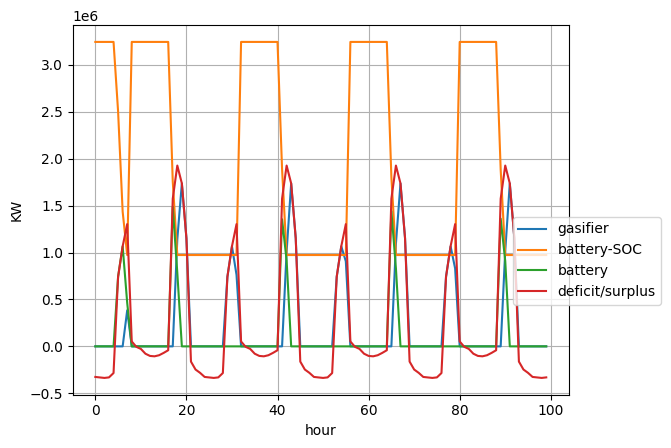

In [68]:
'''
Viewing the operation of the optimized hybrid energy system.
'''
i = 0 # start hour
j = 100 # end hour
x = np.arange(i,j)
# plt.plot(x,solar_array[i:j], label='solar')
plt.plot(x,gasifier_array[i:j], label='gasifier')
plt.plot(x,battery_array[i:j], label = 'battery-SOC')
plt.plot(x,battery_supply_array[i:j], label = 'battery')
# plt.plot(x,-np.array(deficit_array[i:j]), label = 'deficit')
plt.plot(x,-np.array(deficit_array[i:j]), label = 'deficit/surplus')
# plt.plot(x,np.array(deficit_array[i:j]), label = 'surplus')
plt.xlabel("hour")
plt.ylabel("KW")
# plt.plot(x,total_supply[i:j], label = 'total')
plt.grid()
plt.legend(loc='upper right',bbox_to_anchor=(1.2,0.5))